# Introduction to Machine Learning #
Author: Christin Seifert, licensed under the Creative Commons Attribution 3.0 Unported License https://creativecommons.org/licenses/by/3.0/

This is a tutorial for implementing a simple machine learning pipeline aimed at machine learning beginners. 
In this notebook we will
* train classifiers to recognize hand-written digits
* evaluate how well the classifiers do that in general
* dig a little deeper on where they might have problems

It is assumed that you have some general knowledge on 
* what a decision tree is and how it works
* how the Naive Bayes classifier works
* training and testing splits of data sets
* evaluation measures for classification (namely accuracy)

## Setup
First, we import all the python libraries we will need later

In [1]:
# pythons scientific computing package and a random number generator
import numpy as np
import random
from keras.datasets import mnist
# machine learning classifiers and metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# plotting tool
import matplotlib.pyplot as plt

Using TensorFlow backend.


Ok, let's get the data, then and have a look at some examples. It seems that there is a lot of variation for some numbers there. Can you make a decision which number you see wih high confidence for each of the examples?

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

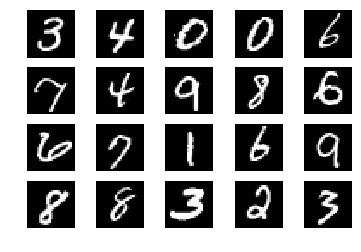

In [3]:
#show 20 random images from the data set
n_images = X_train.shape[0]
n_rows=4
n_cols=5

for i in range(1,n_rows*n_cols+1):
    im_idx = random.randint(0,n_images-1)
    pixels=X_train[im_idx]
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
plt.show()

## Feature Generation
This tutorial works with classical machine learning algorithms. That means, we first have to find suitable features, and then apply a classifier on those features.
A classifier usually requires a vector of numbers (so called _feature vectors_) and an associated label (also called _target_) for each item we want to classify. In our example, we have to magically transform each image into a feature vector. For the sake of simplicity we generate a feature vector of dimension $w\times h$, where $w$ and $h$ are the width and the height of each image. Then we copy the pixel values of the image row-wise to the feature vector. This means, the pixel a location $(i,j)$ in the image ends up at location $i*w + j$ in the feature vector.  As our input data is 28x28 pixels this gives us a feature vector with 784 entries for each image. Each value in the feature vector is between 0 and 255, with 0 indicating a black pixel and 255 a white one.

In [4]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

You might have wondered why there are two variables `X_train` and `X_test`. This is because the library we loaded the data set from already provides a split of the data into training and test set. Let's have a look at the sizes of both. We can see (below), that the training set has 60,000 feature vectors and the testing set has 10,000 feature vectors. The dimensions of the feature vectors is 784. Mathematically, both are matrices and can be written as $X_{train}^{(60000,784)}$ and $X_{test}^{(10000,784)}$. For fun, we will also have a look at the first entry in the training data set. Do you have a chance to identify the digit from that? 

_Note, that in the printout one example looks like a matrix, but it is not! It's just python's way of printing a very long vector in a nice way. You can identify the start and end of a vector by the brackets._

In [5]:
# investigate the size of the feature matrices
print(X_train.shape)
print(X_test.shape)
# inspect one example
print(X_train[1])

(60000, 784)
(10000, 784)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0.   0. 

## Training the Naive Bayes Classifier
Now we are nearly ready to train our first classifier. One thing still needs to be said. Classification is a supervised machine learning task. This means, we give the classifier a feature vector together with the desired output (the target). The targets were also loaded from the original data set and reside in the vector $y_{train}$. Putting things together, the classifier gets a matrix, which contains one row for each image and as many columns as we have features. And it also gets a vector of targets, that is as long as we have images. Thus the number of rows in $X_{train}$ is equal to the length of $y_{train}$. Isn't this neat?

Now we finally can train our first model (a model is a trained classifer). The scikit learn library in python uses standard interfaces to all classifiers. This means, no matter which classifier you want to use, the functions you have to call are always named the same (but they might have different parameters). 

In [6]:
# initialize the model with standard parameters
clf_nb = MultinomialNB()
# train the model
clf_nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluating the Naive Bayes classifier
Ok, nice. We have trained a model. In the code, the model is called `clf_nb`. But, is it a good model? To answer this, we need to evaluate the model on data it has not yet seen, that is on `X_test` and the respective labels `y_test`. 

We do this in two steps:

1. We ask the classifier about its opinion by only giving it the test data (without the labels). This step is called **prediction**. We store the results in a vector `y_test_pred_nb`. 

2. We count how often the classifier's predictions are the same as the correct labels. This step is called **evaluaton**. The counting is already conveniently implemented in the library, so we only need to call a function `accuracy_score()` which returns us the ratio of correct predictions and total items. If you multiply this ratio by 100 you get a value that can be interpreted as "the classifier is ... percent correct on the test data".

Thus, we can conclude, the classifier has an accuracy of approximately 85%. Or in other words, it misclassifies 15% of the examples. Is this good or bad? Has it learned something? What if we got a value of 50%. Would this be good? 

Whether it has learned _something_ can be answered quite easily. We could simply compared it to random guessing. There are 10 classes in the data set (digits from 0 to 9). In the test set, there is an equal amount of examples for each class. Or in other words, the examples are uniformly distributed over the classes. You could easily check this by inspecting `y_test`. If the classifier would randomly guess, which digit it sees, it would have a 10% chance of getting it right. So, it has learned quite a lot already by only looking at the pixel values. 

In [7]:
# make predictions with the NB classifier
y_test_pred_nb = clf_nb.predict(X_test);
a_nb = accuracy_score(y_test, y_test_pred_nb);
print(a_nb)

0.8365


## Training the decision tree classifier
We train the decision tree classifier in a similar manner as we trained the Naive Bayes classifier. Note, that the function calls are equivalent.

_Note: you might notice, that training of a decision tree can take some seconds._

In [8]:
clf_dt = DecisionTreeClassifier();
clf_dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Evaluating the decision tree classifier
Now, let's see how well this model performs on the test set. 

It achieves an accuracy of about 88%, thus getting only 12% of the examples wrong. This seems a bit better than the Naive Bayes classifier.

In [9]:
# make predictions with the decision tree classifier
y_test_pred_dt = clf_dt.predict(X_test)
a_dt = accuracy_score(y_test, y_test_pred_dt)
print(a_dt)

0.8765


## More detailed error analysis
Can we find out more about the mistakes both models still make? If we could, we could probably find ways to improve it. Or it might also be the case that we might find errors in the underlying data (e.g. mislabeled images, images that do not contain digits at all). The latter case is in this example rather unlikely, since this data set has been studied already for a long time and by many different researchers and practicioners. 

### Confusion matrices
One thing we could ask is which digits get often confused with one another. Or more generally, which classes often get confused? We can easily asses this, since we have the predictions and the true labels. So, for each digit we just have to count how often label $l$ in the ground truth is predicted as label $k$. We display this in matrix form, this matrix is called _class confusion matrix_ $C$. Entry $(i,j)$ in this matrix holds the count of how often the target $i$ was predicted as $j$. 

The strength of the confusion (i.e., the total number of misclassified examples) is indicated with a color in the respective cell. 

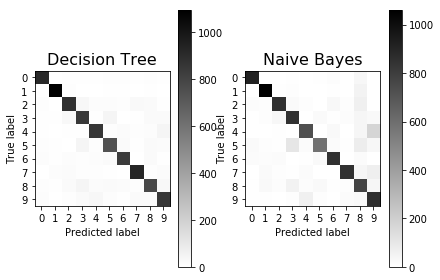

In [10]:
# get the confusion matrices for both classifiers
cm_nb = confusion_matrix(y_test, y_test_pred_nb);
cm_dt = confusion_matrix(y_test, y_test_pred_dt);

# plot the confusion matrices nicely
plt.subplot(1, 2, 1)    
plt.title('Decision Tree', fontsize=16)
plt.imshow(cm_dt, interpolation='nearest',cmap=plt.cm.binary);
plt.tight_layout();
plt.colorbar();
plt.ylabel('True label');
plt.xlabel('Predicted label');
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));

plt.subplot(1, 2, 2) 
plt.title('Naive Bayes', fontsize=16)
plt.imshow(cm_nb, interpolation='nearest',cmap=plt.cm.binary);
plt.tight_layout();
plt.colorbar();
plt.ylabel('True label');
plt.xlabel('Predicted label');
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));


Both plots show a nice dark diagonal. This indicates that most of the examples are predicted correctly (as we know from the accuracy measures). The **decision tree** seems to make its errors all over the place. If you squint a bit, you can see light gray boxes on the off-diagonal. (The visualization could be improved by removing all the diagonal elements and just focus on the errors, the off-diagonal elements). The **Naive Bayes** classifier on the other hand seems to favor 8's and 9's, and especially seems to make mistakes for the 5's. 

## Summary
We have seen a very basic machine learning pipeline. We trained two different classifiers on the same data set and compared them. There are, of course as always ;-) many more things one could try, some of them are:

* have a detailed look a the images that were misclassified
* use more sophisticated features than just pixel values
* try different classifiers
* distort the test images and see how robust the classifiers are to noisy input.

### Take-Aways
1. A classifier needs feature vectors as input, so the input data has first to be transformed in a suitable format.
1. Always train and evaluate on different data set splits.
1. Accuracy alone is not a helpful measure, you need to compare it to something, at least the random baseline.
1. Confusion matrices are a handy tool to pin-point the errors.

That's all for today. 